# Unsupervised Clustering: High-Dimensional Synthetic Dataset 

**1. Importing the packages and creating synthetic data(High-dimensional Data)**

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples

# Generate synthetic high-dimensional dataset

X, y_true = make_blobs(n_samples=1000,
                       n_features=50,
                       centers=4,
                       cluster_std=2.5,
                       random_state=42)

print("Data shape:", X.shape)
print("True clusters:", np.unique(y_true))

Data shape: (1000, 50)
True clusters: [0 1 2 3]


**2. Preprocessing: Scaling + PCA (retain 95% variance)**

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("PCA reduced shape:", X_pca.shape)
print("Explained variance ratio sum:", np.sum(pca.explained_variance_ratio_))

PCA reduced shape: (1000, 31)
Explained variance ratio sum: 0.9514269126430986


**3.  Visualization: t-SNE (on PCA-reduced data) — shows true labels**

t-SNE computed. Shape: (1000, 2)


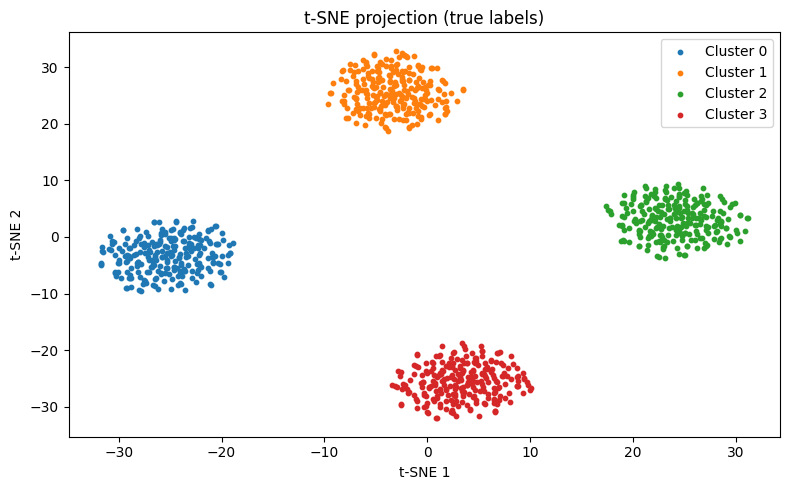

In [21]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, init='pca')
X_tsne = tsne.fit_transform(X_pca)
print("t-SNE computed. Shape:", X_tsne.shape)

plt.figure(figsize=(8,5))
for lab in np.unique(y_true):
    mask = (y_true == lab)
    plt.scatter(X_tsne[mask,0], X_tsne[mask,1], s=10, label=f'Cluster {lab}')
plt.title('t-SNE projection (true labels)')
plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
plt.legend()
plt.tight_layout()
plt.show()

**4. Utility: Clustering evaluation function**

In [22]:
def evaluate_clustering(X, labels):
    """
    Evaluate clustering labels using silhouette, Davies-Bouldin and Calinski-Harabasz.
    We ignore label == -1 (noise) for metrics that require at least 2 clusters.
    """
    unique_labels = set(labels)
    if len(unique_labels) <= 1:
        return {'silhouette': np.nan, 'db': np.nan, 'ch': np.nan}
    mask_valid = labels != -1
    if np.sum(mask_valid) < 2:
        return {'silhouette': np.nan, 'db': np.nan, 'ch': np.nan}
    sil = silhouette_score(X[mask_valid], labels[mask_valid])
    db = davies_bouldin_score(X[mask_valid], labels[mask_valid])
    ch = calinski_harabasz_score(X[mask_valid], labels[mask_valid])
    return {'silhouette': sil, 'db': db, 'ch': ch}

**5.Simple Grid-Search style tuning for each algorithm (using Silhouette on PCA features)**

In [23]:
results = []

# KMeans: n_clusters
for k in [3, 4, 5, 6]:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=500, random_state=42)
    km_labels = km.fit_predict(X_pca)
    res = evaluate_clustering(X_pca, km_labels)
    res.update({'method': 'KMeans', 'params': {'n_clusters': k}})
    results.append(res)

# DBSCAN: eps
for eps in [1.5, 2.0, 2.5, 3.0, 4.0, 5.0]:
    db = DBSCAN(eps=eps, min_samples=3)
    db_labels = db.fit_predict(X_pca)
    unique_labels = set(db_labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    print(f"eps={eps}: clusters={n_clusters}")
    if n_clusters > 1:  # only evaluate if at least 2 clusters formed
        res = evaluate_clustering(X_pca, db_labels)
        res.update({'method': 'DBSCAN', 'params': {'eps': eps}})
        results.append(res)


# Spectral Clustering: n_clusters
for k in [3, 4, 5]:
    sc = SpectralClustering(n_clusters=k, affinity='rbf', random_state=42, n_init=10)
    sc_labels = sc.fit_predict(X_pca)
    res = evaluate_clustering(X_pca, sc_labels)
    res.update({'method': 'Spectral', 'params': {'n_clusters': k}})
    results.append(res)
    
# Agglomerative: n_clusters
for k in [3, 4, 5, 6]:
    ag = AgglomerativeClustering(n_clusters=k, linkage='ward')
    ag_labels = ag.fit_predict(X_pca)
    res = evaluate_clustering(X_pca, ag_labels)
    res.update({'method': 'Agglomerative', 'params': {'n_clusters': k}})
    results.append(res)
    
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='silhouette', ascending=False).reset_index(drop=True)
display(results_df_sorted[['method', 'params', 'silhouette', 'db', 'ch']].head(12))


eps=1.5: clusters=0
eps=2.0: clusters=0
eps=2.5: clusters=11
eps=3.0: clusters=7
eps=4.0: clusters=4
eps=5.0: clusters=4


,method,params,silhouette,db,ch
0,KMeans,{'n_clusters': 4},0.606157,0.594207,1446.982583
1,DBSCAN,{'eps': 4.0},0.606157,0.594207,1446.982583
2,DBSCAN,{'eps': 5.0},0.606157,0.594207,1446.982583
3,Agglomerative,{'n_clusters': 4},0.606157,0.594207,1446.982583
4,Spectral,{'n_clusters': 4},0.591278,0.624856,1314.099838
5,KMeans,{'n_clusters': 5},0.467975,1.879152,1104.932882
6,Agglomerative,{'n_clusters': 5},0.467497,1.944629,1099.111101
7,Spectral,{'n_clusters': 5},0.463186,1.130684,1089.750098
8,KMeans,{'n_clusters': 3},0.462312,0.984464,640.151401
9,Spectral,{'n_clusters': 3},0.462312,0.984464,640.151401


**6.Best configurations per method and final evaluation**

In [24]:
# Choose best params per method (highest silhouette)
best_configs = {}
for method in ['KMeans', 'DBSCAN', 'Spectral', 'Agglomerative']:
    sub = results_df[results_df['method'] == method].copy()
    sub = sub.dropna(subset=['silhouette'])
    if sub.shape[0] == 0:
        best_configs[method] = None
    else:
        idx = sub['silhouette'].idxmax()
        best_configs[method] = sub.loc[idx, 'params']

print("\nBest configs (by silhouette):")
print(best_configs)

# Fit best models and store labels
labels_dict = {}
if best_configs['KMeans'] is not None:
    k = best_configs['KMeans']['n_clusters']
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=500, random_state=42)
    labels_dict['KMeans'] = km.fit_predict(X_pca)

if best_configs['DBSCAN'] is not None:
    eps = best_configs['DBSCAN']['eps']
    db = DBSCAN(eps=eps, min_samples=3)
    labels_dict['DBSCAN'] = db.fit_predict(X_pca)

if best_configs['Spectral'] is not None:
    k = best_configs['Spectral']['n_clusters']
    sc = SpectralClustering(n_clusters=k, affinity='rbf', random_state=42, n_init=10)
    labels_dict['Spectral'] = sc.fit_predict(X_pca)

if best_configs['Agglomerative'] is not None:
    k = best_configs['Agglomerative']['n_clusters']
    ag = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels_dict['Agglomerative'] = ag.fit_predict(X_pca)

best_eval_rows = []

for method, labels in labels_dict.items():
    ev = evaluate_clustering(X_pca, labels)
    ev.update({'method': method, 'params': best_configs[method]})
    best_eval_rows.append(ev)

final_eval_df = pd.DataFrame(best_eval_rows)
display(final_eval_df)


Best configs (by silhouette):
{'KMeans': {'n_clusters': 4}, 'DBSCAN': {'eps': 4.0}, 'Spectral': {'n_clusters': 4}, 'Agglomerative': {'n_clusters': 4}}


,silhouette,db,ch,method,params
0,0.606157,0.594207,1446.982583,KMeans,{'n_clusters': 4}
1,0.606157,0.594207,1446.982583,DBSCAN,{'eps': 4.0}
2,0.591278,0.624856,1314.099838,Spectral,{'n_clusters': 4}
3,0.606157,0.594207,1446.982583,Agglomerative,{'n_clusters': 4}


**8. Visualization: t-SNE colored by clustering labels (for each method)**

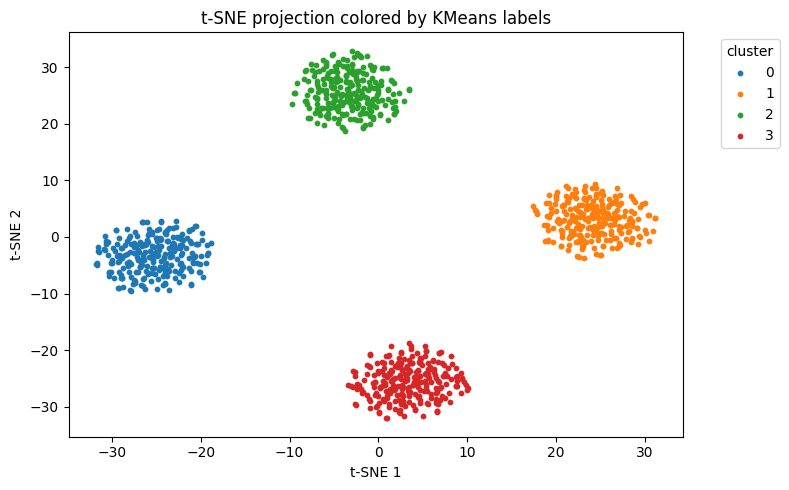

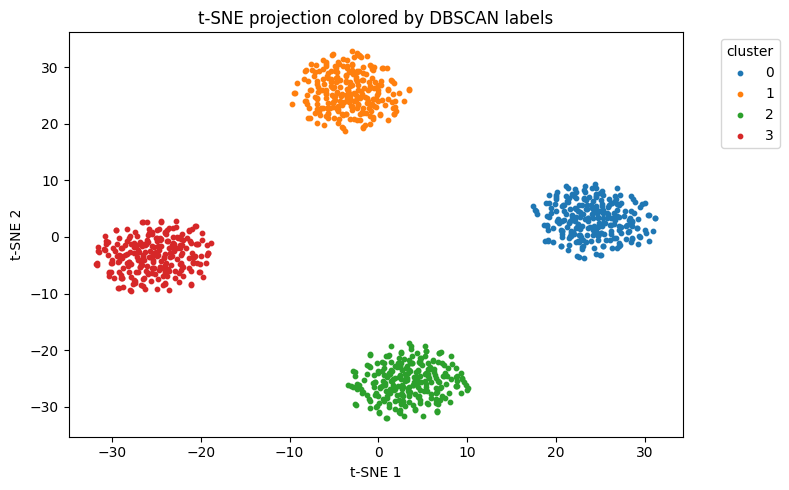

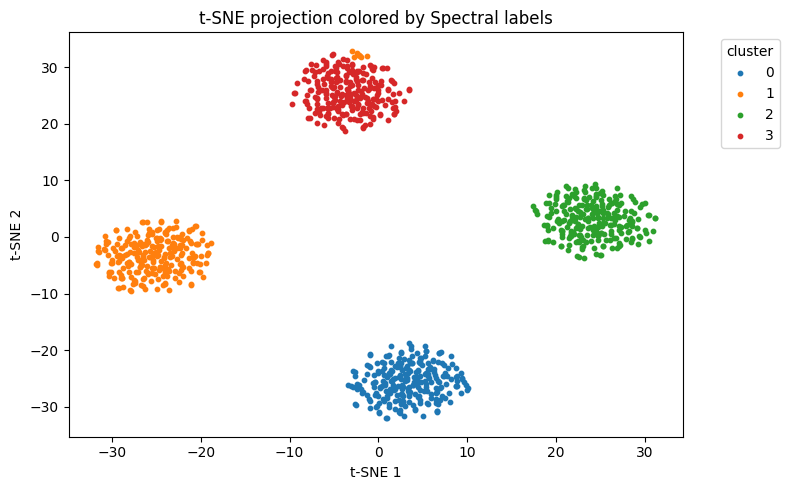

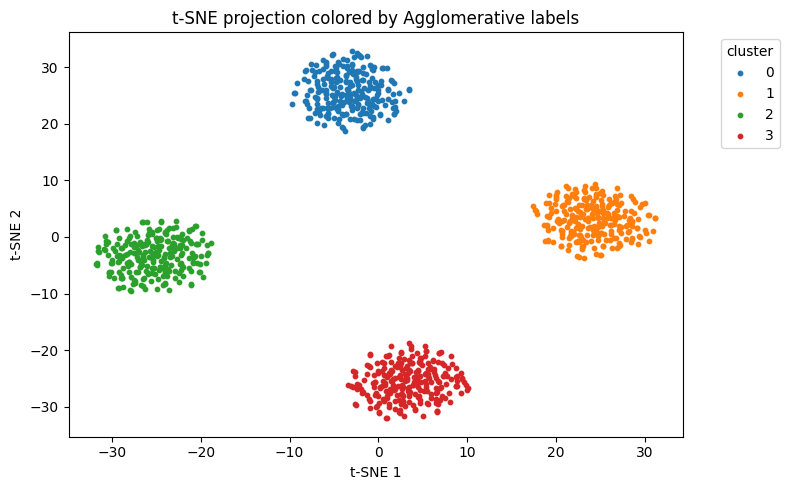

In [25]:
for method, labels in labels_dict.items():
    plt.figure(figsize=(8,5))
    unique = np.unique(labels)
    for lab in unique:
        mask = (labels == lab)
        plt.scatter(X_tsne[mask,0], X_tsne[mask,1], s=10, label=str(lab))
    plt.title(f't-SNE projection colored by {method} labels')
    plt.xlabel('t-SNE 1'); plt.ylabel('t-SNE 2')
    plt.legend(title='cluster', bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()

**9.Silhouette plot for best KMeans (if available)**

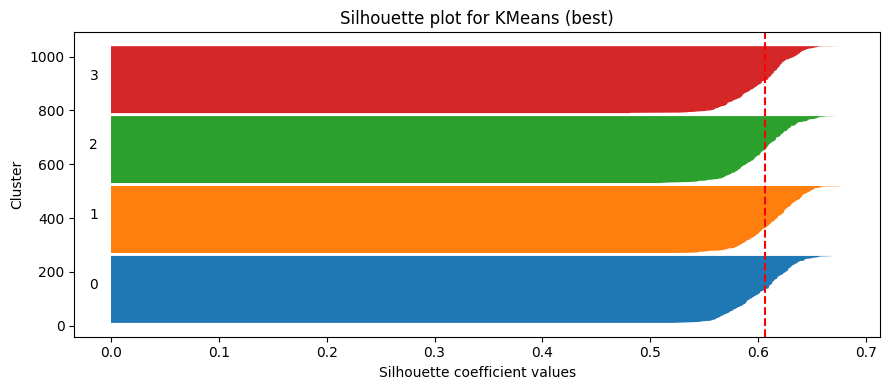

In [26]:
if 'KMeans' in labels_dict:
    labels = labels_dict['KMeans']
    mask = labels != -1
    if np.unique(labels[mask]).shape[0] > 1:
        sil_vals = silhouette_samples(X_pca[mask], labels[mask])
        cluster_ids = np.unique(labels[mask])
        plt.figure(figsize=(9,4))
        y_lower = 10
        for i, cl in enumerate(cluster_ids):
            cl_sil = sil_vals[labels[mask] == cl]
            cl_sil.sort()
            size_cluster = cl_sil.shape[0]
            y_upper = y_lower + size_cluster
            plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cl_sil)
            plt.text(-0.02, y_lower + 0.5 * size_cluster, str(cl))
            y_lower = y_upper + 10
        plt.title('Silhouette plot for KMeans (best)')
        plt.xlabel('Silhouette coefficient values')
        plt.ylabel('Cluster')
        plt.axvline(x=np.mean(sil_vals), color='red', linestyle='--')
        plt.tight_layout()
        plt.show()

**10.Saving the results to CSV file**

In [27]:
res_path = 'clustering_results_summary.csv'
results_df.to_csv(res_path, index=False)
print(f"Saved results summary to {res_path}")

Saved results summary to clustering_results_summary.csv
